In [1]:
# install mlxtend if you haven't already

# ! conda install -y mlxtend

In [2]:
#######################
#       imports       #
#######################
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
import pickle

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, VotingClassifier

from mlxtend.classifier import StackingClassifier # <-- note: this is not from sklearn!

sns.set_style("whitegrid")

# Ensemble Methods

In the previous section we talked about Bagging and how it reduces variance. But there are many more types of ensemble models. The Bagging classifier, allows us to look at the same data through the lens of many bootstrapped samples... But, we're only able to use one classifier to train each bootstrapped sample.

This begs the question: **Can we apply the same logic from bagging to use not just one model, but many different kinds of models as well?**

Fortunately, the answer is **yes** and this section will provide how we can use this "best-of-breed" approach to build different ensemble models.

# Voting Classifier

One of the most common ensemble models is the Voting Classifier. It does what its name implies, looks at the votes of the pre-trained algorithms and gives an output.

<img src="images/ensemble.png" alt="" width="500" height="600"/>

There are 3 different flavors for voting classifier which we will discuss.

- Max Voting
- Average Voting
- Weighted Voting

But, before we get into all the fun stuff, let's load some data and pre-trained models.

In [3]:
df = pd.read_csv('data/dataframe.csv')

In [4]:
df.head()

,column1,column2,label
0,0.987480,-0.727508,0
1,0.099604,-0.448483,0
2,0.376760,-0.414582,0
3,-1.068057,-0.163531,1
4,2.615004,0.125934,1


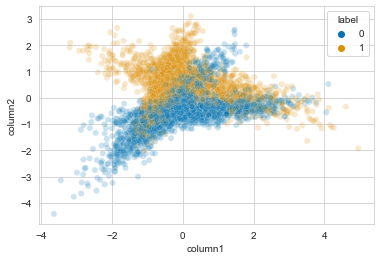

In [5]:
sns.scatterplot(x='column1', y='column2', data=df, hue='label',
           palette='colorblind', alpha=.2);

In [6]:
X_train, X_test, y_train, y_test = train_test_split(df.drop('label', axis=1), 
                                                    df.label, 
                                                    random_state=123
                                                   )

In [7]:
# Load pre-trained/tuned models

model_names = ["lr_model", "knn_model", "rf_model", "et_model"]

for model_name in model_names:
    with open(f"models/{model_name}.pickle", "rb") as pfile:
        exec(f"{model_name} = pickle.load(pfile)")

model_vars = [eval(n) for n in model_names]
model_list = list(zip(model_names, model_vars))

In [8]:
model_list

[('lr_model', LogisticRegression(random_state=1)),
 ('knn_model', KNeighborsClassifier()),
 ('rf_model', RandomForestClassifier(random_state=1)),
 ('et_model', ExtraTreesClassifier(random_state=1))]

In [9]:
# Quick peek at each model performance

for model_name in model_names:
    curr_model = eval(model_name)
    print(f'{model_name} score: {curr_model.score(X_test, y_test)}')

lr_model score: 0.7976
knn_model score: 0.8112
rf_model score: 0.8136
et_model score: 0.8064


## Max Voting

The basic assumption for the max voting algorithm is easy: Take the class that has the largest number of predictions for each model.

**Classifier 1 -> Class 0**

**Classifier 2 -> Class 1**

**Classifier 3 -> Class 1**

In the example above, our max voting method would choose class 1.

In [10]:
# create voting classifier
voting_classifer = VotingClassifier(estimators=model_list,
                                    voting='hard', #<-- sklearn calls this hard voting
                                    n_jobs=-1)
voting_classifer.fit(X_train, y_train)

VotingClassifier(estimators=[('lr_model', LogisticRegression(random_state=1)),
                             ('knn_model', KNeighborsClassifier()),
                             ('rf_model',
                              RandomForestClassifier(random_state=1)),
                             ('et_model',
                              ExtraTreesClassifier(random_state=1))],
                 n_jobs=-1)

In [11]:
# get accuracy (model to beat: RF with 0.8136 accuracy)
y_pred = voting_classifer.predict(X_test)
accuracy_score(y_test, y_pred)

0.816

Not much of an improvement...

## Average Voting

In average voting (aka soft voting), we predict the class labels based on the predicted probabilities $p$ for classifier.

Ultimately, the algorithm will decide which class has the highest sum of probabilities, i.e.,

$$\hat{y} = \arg \max_i \sum_{j=1}^k p_{ij}$$

where $i$ is the number of classes and $k$ is the number of models.



In our example we are looking at a binary classification task with class labels $i \in \{0,1\}$. Imagine our ensemble is making the following predictions:

- $\mathbf{C}_1(\mathbf{x}) \rightarrow [0.9, 0.1]$ 
- $\mathbf{C}_2(\mathbf{x}) \rightarrow [0.8, 0.2]$
- $\mathbf{C}_3(\mathbf{x}) \rightarrow [0.4, 0.6]$ 



Using uniform weights, the average probabilities are the following:

$$p(i_0 | \mathbf{x}) = \frac{0.9 + 0.8 + 0.4}{3} = 0.7 $$

$$p(i_1 | \mathbf{x}) = \frac{0.1 + 0.2 + 0.6}{3} = 0.3 $$

$$\hat y = \arg \max_i [p(i_0 | \mathbf{x}), p(i_1 | \mathbf{x})] = \arg \max_i [0.7, 0.3] = 0 $$

In [12]:
# create voting classifier
voting_classifer = VotingClassifier(estimators=model_list,
                                    voting='soft', #<-- sklearn calls this soft voting
                                    n_jobs=-1)
voting_classifer.fit(X_train, y_train)

VotingClassifier(estimators=[('lr_model', LogisticRegression(random_state=1)),
                             ('knn_model', KNeighborsClassifier()),
                             ('rf_model',
                              RandomForestClassifier(random_state=1)),
                             ('et_model',
                              ExtraTreesClassifier(random_state=1))],
                 n_jobs=-1, voting='soft')

In [13]:
# Get accuracy (model to beat: RF with 0.8136 accuracy)
y_pred = voting_classifer.predict(X_test)
accuracy_score(y_test, y_pred)

0.8152

Still not much of an improvement...

# Weighted Voting

As the name implies, we'll be assigning weights to each model to adjust its contribution to the final prediction. There will be times when you want to give additional weight to models that are performing better to increase the optimization metric.

Mathematically speaking, there is very little change to the Average Voting method we just saw. All we do is add a weight to each probability, i.e.,

$$\hat{y} = \arg \max_i \sum_{j=1}^k w_j p_{ij}$$

where $i$ is the number of classes, $w_j$ is the model weight, and $k$ is the number of models.


Imagine our ensemble is making the same predictions as before:

- $\mathbf{C}_1(\mathbf{x}) \rightarrow [0.9, 0.1]$ 
- $\mathbf{C}_2(\mathbf{x}) \rightarrow [0.8, 0.2]$
- $\mathbf{C}_3(\mathbf{x}) \rightarrow [0.4, 0.6]$ 



Using weights for each model with value $\{0.1, 0.1, 0.8\}$, the results are the following:

$$p(i_0 | \mathbf{x}) = 0.1*0.9 + 0.1*0.8 + 0.8*0.4 = 0.49 $$

$$p(i_1 | \mathbf{x}) = 0.1*0.1 + 0.1*0.2 + 0.8*0.6 = 0.51 $$

$$\hat y = \arg \max_i [p(i_0 | \mathbf{x}), p(i_1 | \mathbf{x})] = \arg \max_i [0.49, 0.51] = 1 $$

In [14]:
# create voting classifier
weights = [1.5,3.8,4.2,2.2]
voting_model = VotingClassifier(estimators=model_list,
                                    voting='soft', 
                                    weights = weights,  #include weights
                                    n_jobs=-1)
voting_model.fit(X_train, y_train)

VotingClassifier(estimators=[('lr_model', LogisticRegression(random_state=1)),
                             ('knn_model', KNeighborsClassifier()),
                             ('rf_model',
                              RandomForestClassifier(random_state=1)),
                             ('et_model',
                              ExtraTreesClassifier(random_state=1))],
                 n_jobs=-1, voting='soft', weights=[1.5, 3.8, 4.2, 2.2])

In [15]:
# Get accuracy (model to beat: RF with 0.8136 accuracy)
y_pred = voting_model.predict(X_test)
accuracy_score(y_test, y_pred)

0.8168

## Tuning weights

In general, tuning the weights for the ensemble classifier is not easy. There is no built-in method to tune or even an educated guess as to where we begin our search. If this were a regression problem, we can take all of the outputs from each of the classifiers and pass them through an OLS model to tune each weight.

In our case, we have a classification problem which makes determining the right coefficients a little more difficult to do. One method is to use a **stacking classifier**.

# Stacking Classifier

Stacking is an ensemble learning technique to combine multiple classification models via a meta-classifier. 

The individual classification models are trained based on the complete training set; then, the meta-classifier is fitted based on the outputs -- meta-features -- of the individual classification models in the ensemble. 

The meta-classifier can either be trained on the predicted class labels or probabilities from the ensemble.

The major difference between the Stacked Classifier and the Voting classifier, is that it uses the outputs of the previous models as features in the meta-classifier to make new predictions.

<img src="images/stacked.png" alt="" width="500" height="600"/>

In [16]:
stacked = StackingClassifier(
    classifiers=model_vars, meta_classifier=LogisticRegression(), use_probas=False)

In [17]:
stacked.fit(X_train, y_train)

StackingClassifier(classifiers=[LogisticRegression(random_state=1),
                                KNeighborsClassifier(),
                                RandomForestClassifier(random_state=1),
                                ExtraTreesClassifier(random_state=1)],
                   meta_classifier=LogisticRegression())

In [18]:
y_pred = stacked.predict(X_test)
accuracy_score(y_test, y_pred)

0.8136

The StackingClassifier didn't give us a marked improvement this time, but for some datasets it will.  We can also further tune the hyperparameters of the individual models or the meta-classifier.

# Recap

In this lesson we covered the different techniques available to ensemble models in sklearn. 

Things to note:
- Regarding voting:
    - Max Voting returns the most common class out of the classifiers (similar to how KNN works)
    - Average Voting returns the most likely class given all of the probabilities 
    - Weighted Voting returns the most likely class given the weighted sum of probabilities/hard classes
- Finding the optimal weights to Weighted Voting can be difficult to achieve
- Stacked Classifiers use the outputs of the models as features into the meta-classifier

## Pros/Cons of Ensemble Methods

**Pros:**
- Reduces variance
- (generally) better model performance

**Cons:**
- Loss of model interpretability
- Computationally expensive

# Resources
- More about [bagging and boosting](http://www.mit.edu/~9.520/spring06/Classes/class10.pdf)
- [StackedClassifier documentation](http://rasbt.github.io/mlxtend/user_guide/classifier/StackingClassifier/)
